The lower limit of $T^{0\nu\beta\beta}_{1/2}$ is given by
$$ T^{0\nu\beta\beta}_{1/2}|_{\text{low}}  = \text{log}(2) t \frac{\epsilon_s}{S(b)} N_0$$

In the large background approximation: $S(b) = \alpha(\text{C.L.})\sqrt{b}$


The sensitivity of a $0\nu\beta\beta$ experiment is proportional to the value
$$\text{figure of merit} = \frac{\epsilon_s}{\sqrt{\epsilon_b}}$$
were $\epsilon_{s, b}$ are the selection efficiencies for signal and background after the selection cuts.

If no cuts are applied, the figure of merit is 1, therefore any cut that improves sensitivity must fullfil
$$\frac{\epsilon_s}{\sqrt{\epsilon_b}} > 1 $$

In [1]:
import os
import sys
import time
import glob
import tables as tb
import pandas as pd
import numpy  as np

from itertools import combinations

from invisible_cities.core.system_of_units import kg, dalton, year, mBq
from invisible_cities.evm.mixer            import get_file_number

from invisible_cities.io.dst_io            import load_dst, load_dsts
from invisible_cities.database.load_db     import RadioactivityData

%matplotlib ipympl
import matplotlib.pyplot as plt

plt.rcParams["figure.max_open_warning"] = False

In [2]:
get_isotope_name  = lambda name: name.split("/")[-5]
get_g4volume_name = lambda name: name.split("/")[-4] 

def load_tracks_with_info(filenames):
    
    tracks = pd.DataFrame()
    for f, filename in enumerate(filenames, 1):
        
        print(f"Processed {f} / {len(filenames)}", end="\r")
        
        try:
            tracks_ = pd.read_hdf(filename, f"Tracking/Tracks").set_index("event")
        except:
            continue
        # energy cut
        energies = tracks_.groupby(level=0).energy.sum()
        sel = (2.40 <= energies) & (energies <= 2.55)
        tracks_ = tracks_.loc[sel].reset_index()
        tracks_["G4Volume"] = get_g4volume_name(filename)
        tracks_["file"]     = get_file_number(filename)

        tracks = pd.concat([tracks, tracks_])
        
    return tracks


def remove_spurious_tracks(tracks, spurious_energy):
    # remove spurious tracks and assign energy to largest energy track:
    # sum spurious track energies to max energy track and
    # correct numb_of_tracks values

    # tracks index must be (event, file) (ie levels 0 and 1)
    tracks = tracks.set_index("trackID", append=True)

    sel_spurious = (tracks.energy < spurious_energy)
    if not sel_spurious.any(): return tracks
    spurious_energies = tracks.loc[sel_spurious].groupby(level=[0, 1]).energy.sum()

    # trackID of max energy track
    trackID = tracks.reset_index(level=2).loc[spurious_energies.index] \
                    .set_index("trackID", append=True).groupby(level=[0, 1]) \
                    .apply(lambda df: df.energy.idxmax()[-1])
    trackID.name = "trackID"

    # sum spurious energy to max energy track
    spurious_energies = pd.merge(spurious_energies, trackID, left_index=True, right_index=True)\
                        .set_index("trackID", append=True)
    tracks.loc[spurious_energies.index, "energy"] += spurious_energies.energy

    # drop spurious
    tracks = tracks.loc[~sel_spurious].reset_index("trackID")
    # correct numb of tracks
    tracks.loc[:, "numb_of_tracks"] = tracks.groupby(level=[0, 1]).trackID.nunique()

    return tracks

In [197]:
act_df, mceff_df = RadioactivityData("next100")
eff_df = pd.read_csv("efficiencies_ic.csv")

index = ["Isotope", "G4Volume"]
eff_df   =  eff_df.set_index(index)
act_df   =  act_df.set_index(index)
mceff_df = mceff_df.set_index(index)

eff_df["exposure"] = ((eff_df.nsim/(mceff_df.MCEfficiency*act_df.TotalActivity * mBq))/year)

In [199]:
exposure   = 100.
enrichment = 0.9
xenon_mass = 100. * kg
N0 = enrichment*(xenon_mass/(136. * dalton))

T12_0nubb = (N0 * np.log(2) * exposure) / eff_df.loc[("0nubb", "ACTIVE")].nsim

print("simulated 0nubb half-life (years):", T12_0nubb)

simulated 0nubb half-life (years): 1.8415720842306204e+24


In [5]:
path = os.path.expandvars("$HOME/NEXT/DATA/production/{isotope}/{g4volume}/prod/isaura/isaura_*.h5")

t0 = time.time()
filenames = glob.glob(path.format(isotope="0nubb", g4volume="*"))
tracks_0nubb = load_tracks_with_info(filenames).set_index(["event", "file"])
print("Time:", (time.time()-t0) / 60)

Time: 0.32871274948120116


In [6]:
t0 = time.time()
filenames = glob.glob(path.format(isotope="214Bi", g4volume="*"))
tracks_214Bi = load_tracks_with_info(filenames).set_index(["event", "file"])
print("Time:", (time.time()-t0) / 60)

Time: 4.86229161421458


In [7]:
t0 = time.time()
filenames = glob.glob(path.format(isotope="208Tl", g4volume="*"))
tracks_208Tl = load_tracks_with_info(filenames).set_index(["event", "file"])
print("Time:", (time.time()-t0) / 60)

Time: 19.79155054887136


In [8]:
spurious_energy = 0.01

# remove spurious
tracks_0nubb = remove_spurious_tracks(tracks_0nubb, spurious_energy)
tracks_214Bi = remove_spurious_tracks(tracks_214Bi, spurious_energy)
tracks_208Tl = remove_spurious_tracks(tracks_208Tl, spurious_energy)

In [9]:
Ns = tracks_0nubb.index.nunique()
Nb = tracks_214Bi.index.nunique() + tracks_208Tl.index.nunique()

## Track multiplicity

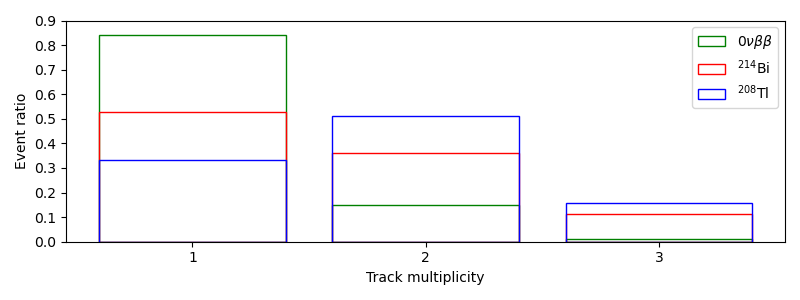

In [73]:
plt.figure(figsize=[8,3])

bins = np.arange(0.5, 4.5, 1)
binc = (bins[1:] + bins[:-1])/2.

# signal
h, _ = np.histogram(tracks_0nubb.groupby(level=[0,1]).numb_of_tracks.max(), bins=bins)
plt.bar(binc, h/h.sum(), label=r"$0\nu\beta\beta$", color="none", edgecolor="g")

# background
h, _ = np.histogram(tracks_214Bi.groupby(level=[0,1]).numb_of_tracks.max(), bins=bins)
plt.bar(binc, h/h.sum(), label=r"$^{214}$Bi", color="none", edgecolor="r")

h, _ = np.histogram(tracks_208Tl.groupby(level=[0,1]).numb_of_tracks.max(), bins=bins)
plt.bar(binc, h/h.sum(), label=r"$^{208}$Tl", color="none", edgecolor="b")

plt.legend()
plt.ylabel("Event ratio")
plt.xlabel("Track multiplicity")
plt.xticks(binc)
plt.yticks(np.arange(0, 1, 0.1))
plt.tight_layout()

In [74]:
# ntracks = 1
n = 1

sel = tracks_0nubb.numb_of_tracks <= n
es = tracks_0nubb.loc[sel].index.size / Ns

npass  = 0
# 214Bi
sel = tracks_214Bi.numb_of_tracks <= n
npass += tracks_214Bi.loc[sel].index.size
# 208Tl
sel = tracks_208Tl.numb_of_tracks <= n
npass += tracks_208Tl.loc[sel].index.size
eb = npass / Nb

print(f"ntracks <= {n} cut: fom =", round(es/np.sqrt(eb), 2))

ntracks <= 1 cut: fom = 1.43


In [75]:
print("1 track selection efficiency")
print("----------------------------")
print("0nubb:", (tracks_0nubb.numb_of_tracks == 1).sum()/Ns)
print("214Bi:", (tracks_214Bi.numb_of_tracks == 1).sum()/tracks_214Bi.index.nunique())
print("208Tl:", (tracks_208Tl.numb_of_tracks == 1).sum()/tracks_208Tl.index.nunique())

tracks_0nubb = tracks_0nubb.loc[tracks_0nubb.numb_of_tracks == 1]
tracks_214Bi = tracks_214Bi.loc[tracks_214Bi.numb_of_tracks == 1]
tracks_208Tl = tracks_208Tl.loc[tracks_208Tl.numb_of_tracks == 1]

1 track selection efficiency
----------------------------
0nubb: 0.8389203845205817
214Bi: 0.5187250996015936
208Tl: 0.32524519820187986


## Fiducialization

Efficiency: 0.9453503746143676


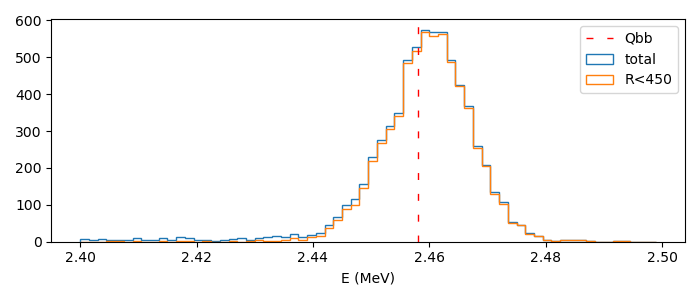

In [76]:
plt.figure(figsize=[7, 3])

tracks = tracks_0nubb

rmax = 450
bins = np.arange(2.40, 2.50, 0.0015)

plt.hist(tracks_0nubb.energy, bins=bins, histtype="step", label="total")

# R cut
sel = (tracks_0nubb.r_max < rmax)
print("Efficiency:", sel.sum()/tracks_0nubb.index.size)
plt.hist( tracks_0nubb.loc[sel].groupby(level=[0,1]).energy.sum()
        , bins=bins, histtype="step", label=f"R<{rmax}")

Qbb = 2.458
plt.axvline(Qbb, c="r", linewidth=1, linestyle=(0, (5, 10)), label="Qbb")

plt.xlabel("E (MeV)")

plt.legend()
plt.tight_layout();

In [77]:
rmax = 450

print("Fiducial selection efficiency")
print("-----------------------------")
print("0nubb:", (tracks_0nubb.r_max < rmax).sum()/tracks_0nubb.index.size)
print("214Bi:", (tracks_214Bi.r_max < rmax).sum()/tracks_214Bi.index.size)
print("208Tl:", (tracks_208Tl.r_max < rmax).sum()/tracks_208Tl.index.size)


tracks_0nubb = tracks_0nubb.loc[tracks_0nubb.r_max < rmax]
tracks_214Bi = tracks_214Bi.loc[tracks_214Bi.r_max < rmax]
tracks_208Tl = tracks_208Tl.loc[tracks_208Tl.r_max < rmax]

Fiducial selection efficiency
-----------------------------
0nubb: 0.9453503746143676
214Bi: 0.9165386584741424
208Tl: 0.7107743050102089


## ROI and $E_{b_2}$

In [78]:
# no overlap
print("No overlap between blobs efficiencies:")
print("-------------------------------------")

sel = tracks_0nubb.ovlp_blob_energy >0
print("0nubb:", round(sel.sum()/len(sel), 3))
tracks_0nubb = tracks_0nubb.loc[~sel]

sel = tracks_208Tl.ovlp_blob_energy >0
print("208Tl:", round(sel.sum()/len(sel), 3))
tracks_208Tl = tracks_208Tl.loc[~sel]

sel = tracks_214Bi.ovlp_blob_energy >0
print("214Bi:", round(sel.sum()/len(sel), 3))
tracks_214Bi = tracks_214Bi.loc[~sel]

No overlap between blobs efficiencies:
-------------------------------------
0nubb: 0.018
208Tl: 0.004
214Bi: 0.004


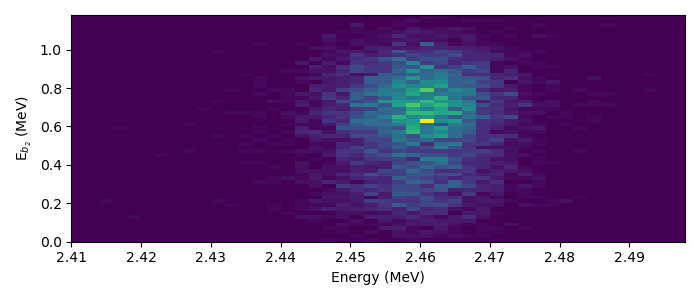

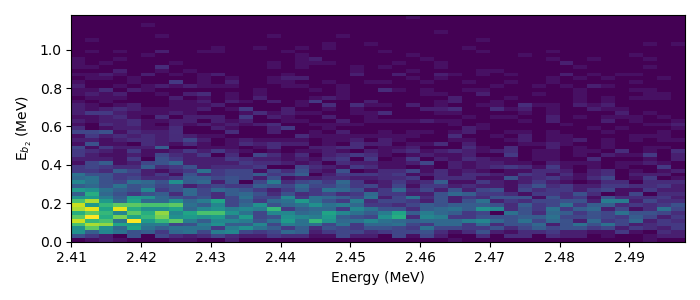

In [79]:
plt.figure(figsize=[7, 3])

xbins = np.arange(2.41, 2.50, 0.002)
ybins = np.arange(0, 1.20, 0.02)
binc = (bins[1:] + bins[:-1])/2.

plt.hist2d( tracks_0nubb.energy, tracks_0nubb.eblob2, bins=[xbins, ybins]
          , density=True, label=r"$0\nu\beta\beta$")

plt.xlabel("Energy (MeV)")
plt.ylabel(r"E$_{b_2}$ (MeV)")
plt.tight_layout()

plt.figure(figsize=[7, 3])

xbins = np.arange(2.41, 2.50, 0.002)
ybins = np.arange(0, 1.20, 0.02)
binc = (bins[1:] + bins[:-1])/2.

plt.hist2d( tracks_208Tl.energy, tracks_208Tl.eblob2, bins=[xbins, ybins]
          , density=True, label=r"$0\nu\beta\beta$")

plt.xlabel("Energy (MeV)")
plt.ylabel(r"E$_{b_2}$ (MeV)")
plt.tight_layout()

In [80]:
ROI = np.arange(2.42, 2.50, 0.002)
combs = list(combinations(ROI, 2))

s = []
b = []
for i, comb in enumerate(combs):
    emin, emax = comb
    st  = tracks_0nubb.loc[(emin<=tracks_0nubb.energy) & (tracks_0nubb.energy<emax)]
    bt1 = tracks_208Tl.loc[(emin<=tracks_208Tl.energy) & (tracks_208Tl.energy<emax)]
    bt2 = tracks_214Bi.loc[(emin<=tracks_214Bi.energy) & (tracks_214Bi.energy<emax)]
    s.append( len(st)             /Ns)
    b.append((len(bt1) + len(bt2))/Nb)
s = np.array(s)
b = np.array(b)

roi = combs[np.argmax(s/np.sqrt(b))]

print("f.o.m:", np.max(s/np.sqrt(b)))

f.o.m: 3.3647746289377047


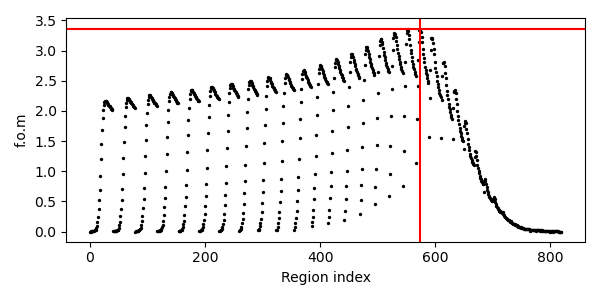

In [81]:
plt.figure(figsize=[6, 3])
plt.scatter(range(len(s)), s/np.sqrt(b), s=2, color="k")

plt.axvline(np.argmax(s/np.sqrt(b)), c="r")
plt.axhline(np.max   (s/np.sqrt(b)), c="r")

plt.xlabel("Region index")
plt.ylabel("f.o.m")
plt.tight_layout();

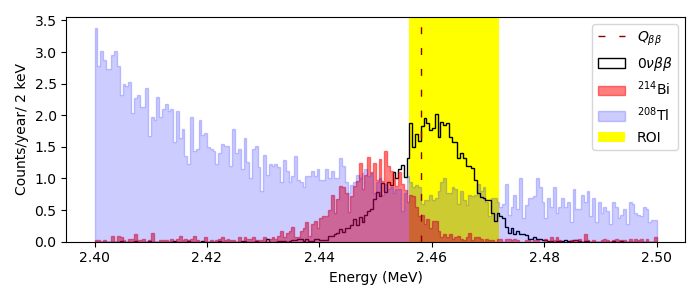

In [82]:
fig = plt.figure(figsize=[7, 3])
ax = fig.add_subplot(111)

bins = np.arange(2.40, 2.50, 0.0005)
binc = (bins[1:] + bins[:-1])/2.

# signal
h, _ = np.histogram(tracks_0nubb.energy, bins=bins)
ax.stairs(h/100, bins, label=r"$0\nu\beta\beta$", facecolor="none", edgecolor="k", fill=True)


# 214Bi
df = eff_df.loc[(slice(None), "214Bi"), :]
T  = (df.nreco/df.nreco.sum() * df.exposure).sum()
h, _ = np.histogram(tracks_214Bi.energy, bins=bins)
ax.stairs(h/T, bins, label=r"$^{214}$Bi", facecolor="r", edgecolor="r", alpha=0.5, fill=True)


# 208Tl
df = eff_df.loc[(slice(None), "208Tl"), :]
T  = (df.nreco/df.nreco.sum() * df.exposure).sum()
h, _ = np.histogram(tracks_208Tl.energy, bins=bins)
ax.stairs(h/T, bins, label=r"$^{208}$Tl", facecolor="b", edgecolor="b", alpha=0.2, fill=True)

# ROI
Qbb = 2.458
plt.axvline(Qbb, c="darkred", linewidth=1, linestyle=(0, (5, 10)), label=r"$Q_{\beta\beta}$")
ax.set_ylim(ax.get_ylim())
ax.fill_betweenx(ax.get_ylim(), roi[0], roi[1], edgecolor="none", facecolor="yellow", label="ROI")

ax.set_ylabel("Counts/year/ 2 keV")
ax.set_xlabel("Energy (MeV)")
ax.legend()
fig.tight_layout()

In [83]:
# tracks_0nubb = tracks_0nubb.loc[(roi[0]<=tracks_0nubb.energy) & (tracks_0nubb.energy<roi[1])]
# tracks_208Tl = tracks_208Tl.loc[(roi[0]<=tracks_208Tl.energy) & (tracks_208Tl.energy<roi[1])]
# tracks_214Bi = tracks_214Bi.loc[(roi[0]<=tracks_214Bi.energy) & (tracks_214Bi.energy<roi[1])]

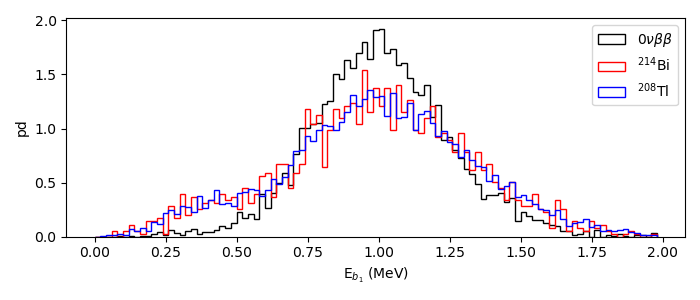

In [84]:
plt.figure(figsize=[7, 3])

bins = np.arange(0, 2.0, 0.02)
binc = (bins[1:] + bins[:-1])/2.

plt.hist(tracks_0nubb.eblob1, bins=bins, density=True, histtype="step", color="k", label=r"$0\nu\beta\beta$")
plt.hist(tracks_214Bi.eblob1, bins=bins, density=True, histtype="step", color="r", label=r"$^{214}$Bi")
plt.hist(tracks_208Tl.eblob1, bins=bins, density=True, histtype="step", color="b", label=r"$^{208}$Tl")

plt.ylabel("pd")
plt.xlabel(r"E$_{b_1}$ (MeV)")
plt.legend()
plt.tight_layout()

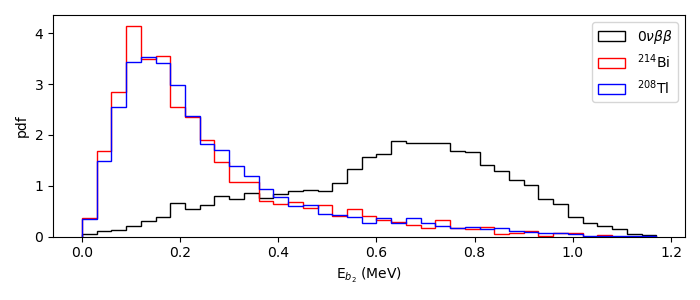

In [85]:
plt.figure(figsize=[7, 3])

bins = np.arange(0, 1.20, 0.03)
binc = (bins[1:] + bins[:-1])/2.

plt.hist(tracks_0nubb.eblob2, bins=bins, density=True, histtype="step", color="k", label=r"$0\nu\beta\beta$")
plt.hist(tracks_214Bi.eblob2, bins=bins, density=True, histtype="step", color="r", label=r"$^{214}$Bi")
plt.hist(tracks_208Tl.eblob2, bins=bins, density=True, histtype="step", color="b", label=r"$^{208}$Tl")

plt.ylabel("pdf")
plt.xlabel(r"E$_{b_2}$ (MeV)")
plt.legend()
plt.tight_layout()

In [86]:
# figure of merit
Eb2 = np.arange(0, 1.2, 0.02)

s = []
b = []

for eb2 in Eb2:
    s.append( np.sum((tracks_0nubb.eblob2>eb2) & (roi[0]<=tracks_0nubb.energy) & (tracks_0nubb.energy<roi[1]))/ Ns)
    b.append((np.sum((tracks_214Bi.eblob2>eb2) & (roi[0]<=tracks_214Bi.energy) & (tracks_214Bi.energy<roi[1]))
            + np.sum((tracks_208Tl.eblob2>eb2) & (roi[0]<=tracks_208Tl.energy) & (tracks_208Tl.energy<roi[1])))/ Nb)

s = np.array(s)
b = np.array(b)

fom = s/np.sqrt(b)
fom[fom == np.inf] = 0

print("            f.o.m max", round(np.max(fom), 2))
print("    Signal efficiency", round(s[np.argmax(fom)], 5))
print("Background efficiency", round(b[np.argmax(fom)], 5))

            f.o.m max 7.32
    Signal efficiency 0.34792
Background efficiency 0.00226


/var/folders/x0/7w5c6z2j3n3dc8rqww2szh200000gn/T/ipykernel_12652/3216304257.py:15: RuntimeWarning: divide by zero encountered in true_divide
  fom = s/np.sqrt(b)


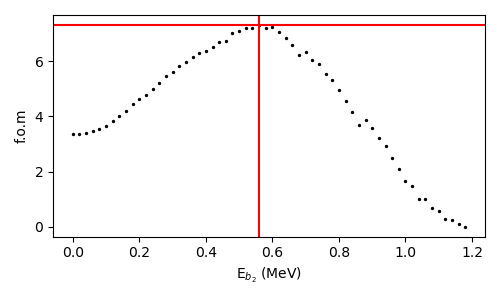

In [87]:
plt.figure(figsize=[5, 3])
plt.scatter(Eb2, fom, s=2, c="k")

plt.axvline(Eb2[np.argmax(fom)], c="r")
plt.axhline(        np.max(fom), c="r")

plt.ylabel("f.o.m")
plt.xlabel(r"E$_{b_2}$ (MeV)")
plt.tight_layout();

In [88]:
df = eff_df.loc[(slice(None), ("208Tl", "214Bi")), :]
T  = (df.nreco/df.nreco.sum() * df.exposure).sum()

c = b[np.argmax(fom)]*Nb/T
print("Background rate (counts/year):", c)

Background rate (counts/year): 2.7589804787064427


## $T^{0\nu\beta\beta}_{1/2}$

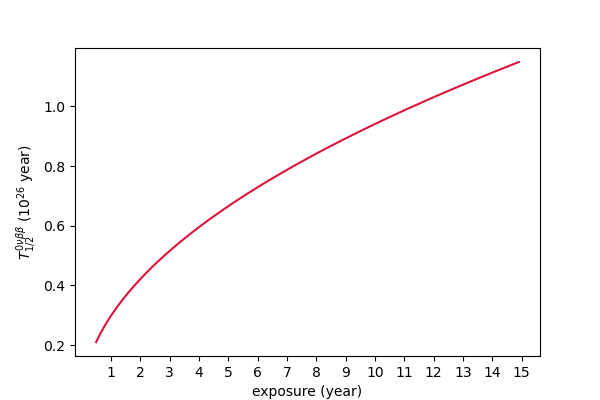

In [89]:
df = eff_df.loc[(slice(None), ("208Tl", "214Bi")), :]
T  = (df.nreco/df.nreco.sum() * df.exposure).sum()
alpha = 1.64 # 90 % CL

tmax = 15
t = np.arange(0.5, tmax, 0.1)

exposure   = 100.
enrichment = 0.9
xenon_mass = 100. * kg

# correct xenon_mass by fiducial volume
density = xenon_mass / (np.pi*490**2*1200)
xenon_mass = density * (np.pi*450**2*1200)

N0 = enrichment*(xenon_mass/(136. * dalton))

T12 = np.log(2) * t * np.max(fom) * N0 / (np.sqrt(Nb/T * t) * alpha)

plt.figure(figsize=[6, 4])
plt.plot(t, T12/1e26, color="crimson")
plt.xlabel("exposure (year)")
plt.ylabel(r"$T^{0\nu\beta\beta}_{1/2}$ ($10^{26}$ year)")
plt.xticks(range(1, tmax+1));

## PDFs

In [90]:
os.environ["ZFIT_DISABLE_TF_WARNINGS"] = "1"
import zfit
import hist

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/__init__.py:50: UserWarning: This is an ALPHA version of zfit for feature testing, do NOT use it in production! It is NOT stable and contains bugs and untested features. For production use, please use the last beta stable version of zfit.
  warnings.warn(


### Energy

In [380]:
energy_obs_ext = zfit.Space("energy", limits=(2.40, 2.50))
energy_obs     = zfit.Space("energy", limits=(2.42, 2.49))

data = zfit.Data.from_numpy (obs=energy_obs_ext, array=tracks_0nubb.energy.values)
pdf_energy_0nubb = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")

data = zfit.Data.from_numpy (obs=energy_obs_ext, array=tracks_214Bi.energy.values)
pdf_energy_214Bi = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")

data = zfit.Data.from_numpy (obs=energy_obs_ext, array=tracks_208Tl.energy.values)
pdf_energy_208Tl = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")

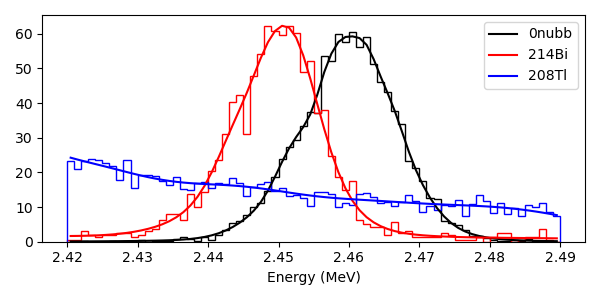

In [381]:
plt.figure(figsize=[6, 3])

bins = np.arange(2.42, 2.49, 0.001)
binc = (bins[1:] + bins[:-1])/2.

plt.hist(tracks_0nubb.energy, bins=bins, density=True, histtype="step", color="k")
plt.hist(tracks_214Bi.energy, bins=bins, density=True, histtype="step", color="r")
plt.hist(tracks_208Tl.energy, bins=bins, density=True, histtype="step", color="b")

plt.plot(binc, pdf_energy_0nubb.pdf(binc), label="0nubb", color="k")
plt.plot(binc, pdf_energy_214Bi.pdf(binc), label="214Bi", color="r")
plt.plot(binc, pdf_energy_208Tl.pdf(binc), label="208Tl", color="b")

plt.xlabel("Energy (MeV)")
plt.legend()
plt.tight_layout()

### Energy resolution

In [382]:
from scipy.signal import find_peaks, peak_widths

In [383]:
signal = pdf_energy_0nubb.pdf(binc).numpy()

peaks, _ = find_peaks(signal)
fwhm, heigh, x1, x2 = peak_widths(signal, peaks, rel_height=0.5)

x_to_energy = lambda x: (binc[-1] - binc[0])/len(signal)*x + binc[0]
R = (x_to_energy(x2) - x_to_energy(x1)) / x_to_energy(peaks) * 100

print("Energy resolution FWHM (%)", R)

Energy resolution FWHM (%) [0.62197527]


In [365]:
# gaussian fit
import zfit

obs = zfit.Space('x', limits=(2.42, 2.49))

mu    = zfit.Parameter(   "mu", 2.45, 2.42, 2.49)
sigma = zfit.Parameter("sigma", 0.10, 0.00, 5.00)

gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)
minimizer = zfit.minimize.Minuit()

In [384]:
data = zfit.Data.from_numpy(obs=obs, array=tracks_0nubb.energy.values)

nll = zfit.loss.UnbinnedNLL(model=gauss, data=data)

result = minimizer.minimize(nll)
print(result)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu1, sigma]] data=[<zfit.core.data.Data object at 0x7fec1c97d970>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 6.1e-12 │ 1000        │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value    at limit
------  ----------  ----------
mu1        2.45981       False
sigma   0.00719675       False


In [390]:
# plt.figure(figsize=[5, 3])

# plt.plot  (x_to_energy(range(len(signal))), signal, color="k")
# plt.plot  (x_to_energy(peaks), signal[peaks], "x", color="r")
# plt.hlines(heigh, x_to_energy(x1), x_to_energy(x2), color="r")


# plt.xlabel("Energy (MeV)")
# plt.tight_layout()

### $E_{b_2}$

In [96]:
energy_obs     = zfit.Space("eblob2", limits=(0, 1.2))

data = zfit.Data.from_numpy (obs=energy_obs, array=tracks_0nubb.eblob2.values)
pdf_energy_0nubb = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")

data = zfit.Data.from_numpy (obs=energy_obs, array=tracks_214Bi.eblob2.values)
pdf_energy_214Bi = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")

data = zfit.Data.from_numpy (obs=energy_obs, array=tracks_208Tl.eblob2.values)
pdf_energy_208Tl = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")

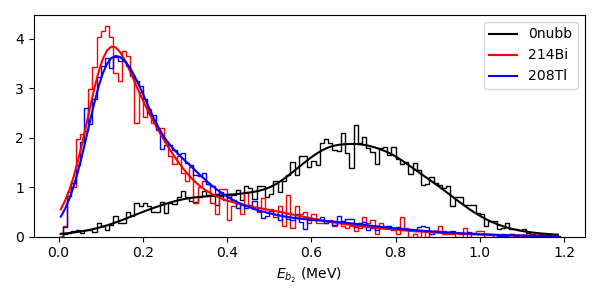

In [97]:
plt.figure(figsize=[6, 3])

bins = np.arange(0, 1.2, 0.01)
binc = (bins[1:] + bins[:-1])/2.

plt.hist(tracks_0nubb.eblob2, bins=bins, density=True, histtype="step", color="k")
plt.hist(tracks_214Bi.eblob2, bins=bins, density=True, histtype="step", color="r")
plt.hist(tracks_208Tl.eblob2, bins=bins, density=True, histtype="step", color="b")

plt.plot(binc, pdf_energy_0nubb.pdf(binc), label="0nubb", color="k")
plt.plot(binc, pdf_energy_214Bi.pdf(binc), label="214Bi", color="r")
plt.plot(binc, pdf_energy_208Tl.pdf(binc), label="208Tl", color="b")

plt.xlabel(r"$E_{b_2}$ (MeV)")
plt.legend()
plt.tight_layout()

In [98]:
save_data = False
data_filename = "selected_data.h5"

if save_data:
    with tb.open_file(data_filename, mode="w", title="PDFs") as h5file:
        
        # 208Tl
        g = h5file.create_group("/", "Tl208", "Tl208")
        h5file.create_array(g, "energy", tracks_208Tl.energy.values, "energy")
        h5file.create_array(g, "eblob2", tracks_208Tl.eblob2.values, "eblob2")
        
        # 214Bi
        g = h5file.create_group("/", "Bi214", "Bi214")
        h5file.create_array(g, "energy", tracks_214Bi.energy.values, "energy")
        h5file.create_array(g, "eblob2", tracks_214Bi.eblob2.values, "eblob2")
        
        # 0nubb
        g = h5file.create_group("/", "bb0nu", "bb0nu")
        h5file.create_array(g, "energy", tracks_0nubb.energy.values, "energy")
        h5file.create_array(g, "eblob2", tracks_0nubb.eblob2.values, "eblob2")

### ROI efficiencies (for pdf-based event mixer)

In [359]:
ic_efficiencies = "efficiencies_ic.csv"
eff_ic = pd.read_csv(ic_efficiencies).set_index(["Isotope", "G4Volume"])

pdf_roi = 2.42, 2.49

n_roi_0nubb = tracks_0nubb.energy.between(*pdf_roi).sum()
print("0nubb eff:", n_roi_0nubb/eff_ic.loc[("0nubb", "ACTIVE")].nreco)

sel = tracks_208Tl.energy.between(*pdf_roi)
n_roi_208Tl = tracks_208Tl.loc[sel].value_counts("G4Volume").to_frame()

sel = tracks_214Bi.energy.between(*pdf_roi)
n_roi_214Bi = tracks_214Bi.loc[sel].value_counts("G4Volume").to_frame()

0nubb eff: 0.5039929723686312


In [360]:
n_roi_208Tl.loc[:, "Isotope"] = "208Tl"
n_roi_214Bi.loc[:, "Isotope"] = "214Bi"

n_roi = pd.concat([n_roi_208Tl, n_roi_214Bi])
n_roi.loc["ACTIVE"] = (n_roi_0nubb, "0nubb")
n_roi = n_roi.rename({0: "nevts"}, axis=1).reset_index()

In [361]:
save = True
if save:
    n_roi.to_csv("efficiencies_selection.csv", index=False)

## Contribution in ROI

In [330]:
event_rates = (n_roi.set_index(["Isotope", "G4Volume"]).nevts / eff_df.exposure).to_frame()
event_rates = event_rates.loc[(("208Tl", "214Bi"),), :].fillna(0).rename({0: "rate"}, axis=1).sort_index(level=1)

In [331]:
# is upper limit?
event_rates.loc[:, "upperlim"] = False

# 214Bi
event_rates.loc[("214Bi", "ICS")       , "upperlim"] = True
event_rates.loc[("214Bi", "FIELD_RING"), "upperlim"] = True
event_rates.loc[("214Bi", "SIPM_BOARD"), "upperlim"] = True
event_rates.loc[("214Bi", "VESSEL")    , "upperlim"] = True
event_rates.loc[("214Bi", "SHIELDING_LEAD"), "upperlim"] = True

event_rates.loc[("208Tl", "ICS")       , "upperlim"] = True
event_rates.loc[("208Tl", "FIELD_RING"), "upperlim"] = True
event_rates.loc[("208Tl", "SIPM_BOARD"), "upperlim"] = True
event_rates.loc[("208Tl", "VESSEL")    , "upperlim"] = True

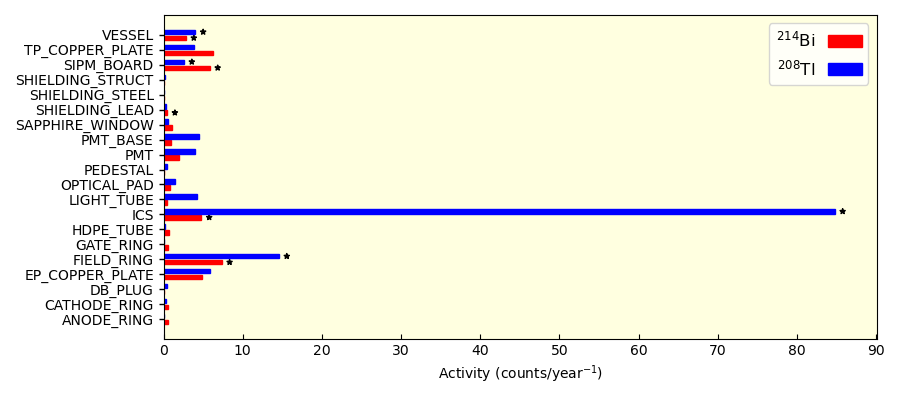

In [350]:
width = 3
dx = 10
volumes = event_rates.index.get_level_values("G4Volume").unique()
X = np.arange(0, dx*len(volumes), dx)
tick_width = 1

fig = plt.figure(figsize=[9, 4])
ax1 = fig.add_subplot(111)

# 214Bi
color="r"
b1 = ax1.barh( X-width/2.-tick_width/2., event_rates.loc["214Bi"].rate
             , height=width, color=color, edgecolor=color, label=r"$^{214}$Bi")
# 208Tl
color="b"
b2 = ax1.barh( X+width/2.+tick_width/2., event_rates.loc["208Tl"].rate
             , height=width, color=color, edgecolor=color, label=r"$^{208}$Tl")


# upper limits
colors = np.repeat("none", len(volumes)).astype(object)
colors[event_rates.loc["214Bi"].upperlim] = "black"
plt.scatter( event_rates.loc["214Bi"].rate + 1, X-width/2.-tick_width/2, marker="*"
           , color=colors, s=15)

colors = np.repeat("none", len(volumes)).astype(object)
colors[event_rates.loc["208Tl"].upperlim] = "black"
plt.scatter( event_rates.loc["208Tl"].rate + 1, X+width/2.+tick_width/2., marker="*"
           , color=colors, s=15)

ax1.set_xticks(np.arange(0, event_rates.rate.max()+10, 10))
ax1.set_yticks(X)
ax1.set_yticklabels(volumes, rotation=0)
ax1.tick_params(axis='y', width=tick_width)
ax1.tick_params(axis='x', direction="in")
ax1.ticklabel_format(axis="x", scilimits=(-1, 2))
ax1.set_xlabel("Activity (counts/year$^{-1}$)")
ax1.legend([b1, b2], [b1.get_label(), b2.get_label()], loc="upper right", fontsize=12, markerfirst=False);

ax1.set_facecolor("lightyellow")
fig.tight_layout()

In [221]:
# save_pdfs = True
# pdfs_filename = "pdfs.h5"

# if save_pdfs:
#     with tb.open_file(pdfs_filename, mode="w", title="PDFs") as h5file:
#         h5file.create_group("/", "Tl208", "Tl208")
#         h5file.create_group("/", "Bi214", "Bi214")
#         h5file.create_group("/", "bb0nu", "bb0nu")
        
#         # ENERGY
#         bin_edges = np.arange(2.40, 2.50, 0.001)
#         # 208Tl
#         pdf, _ = np.histogram(tracks_208Tl.energy, bins=bin_edges, density=True)
#         g = h5file.create_group("/Tl208", "energy")
#         h5file.create_array(g, "bin_edges", bin_edges, "Binning")
#         h5file.create_array(g,       "pdf", pdf, "Binning")
        
#         # 214Bi
#         pdf, _ = np.histogram(tracks_214Bi.energy, bins=bin_edges, density=True)
#         g = h5file.create_group("/Bi214", "energy")
#         h5file.create_array(g, "bin_edges", bin_edges, "Binning")
#         h5file.create_array(g,       "pdf", pdf, "Binning")
        
#         # 0nubb
#         pdf, _ = np.histogram(tracks_0nubb.energy, bins=bin_edges, density=True)
#         g = h5file.create_group("/bb0nu", "energy")
#         h5file.create_array(g, "bin_edges", bin_edges, "Binning")
#         h5file.create_array(g,       "pdf", pdf, "Binning")
        
          
#         # BLOB2-ENERGY
#         bin_edges = np.arange(0, 1.0, 0.03)
#         # 208Tl
#         pdf, _ = np.histogram(tracks_208Tl.eblob2, bins=bin_edges, density=True)
#         g = h5file.create_group("/Tl208", "eblob2")
#         h5file.create_array(g, "bin_edges", bin_edges, "Binning")
#         h5file.create_array(g,       "pdf", pdf, "Binning")
        
#         # 214Bi
#         pdf, _ = np.histogram(tracks_214Bi.eblob2, bins=bin_edges, density=True)
#         g = h5file.create_group("/Bi214", "eblob2")
#         h5file.create_array(g, "bin_edges", bin_edges, "Binning")
#         h5file.create_array(g,       "pdf", pdf, "Binning")
        
#         # 0nubb
#         pdf, _ = np.histogram(tracks_0nubb.eblob2, bins=bin_edges, density=True)
#         g = h5file.create_group("/bb0nu", "eblob2")
#         h5file.create_array(g, "bin_edges", bin_edges, "Binning")
#         h5file.create_array(g,       "pdf", pdf, "Binning")

In [98]:
gaussian_fit = True

if gaussian_fit:
    mu  = zfit.Parameter( 'mu', 0)
    sig = zfit.Parameter('sig', 0)

In [112]:
if gaussian_fit:
    # gaussian fit
    emin, emax = 2.445, 2.47
    obs = zfit.Space('E', (emin, emax))

    mu.lower = emin
    mu.upper = emax
    mu.set_value((emax+emin)/2.)

    sig.lower = 0
    sig.upper = emax - emin
    sig.set_value((emax-emin)/2.)

    model     = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sig)
    minimizer = zfit.minimize.Minuit(gradient=True)

In [113]:
if gaussian_fit:
    data = tracks_0nubb.energy.values
    data = data[(emin<=data)& (data<=emax)]

    nll = zfit.loss.UnbinnedNLL(model, tracks_0nubb.energy.values)

    result = minimizer.minimize(nll)
    print(result)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sig]] data=[<zfit.core.data.Data object at 0x7fb00188ef10>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ False   │ False       │ False            │ 1.5e+06 │ 992.8398    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name          value    at limit
------  -----------  ----------
mu          2.46439       False
sig     4.47019e-06       False


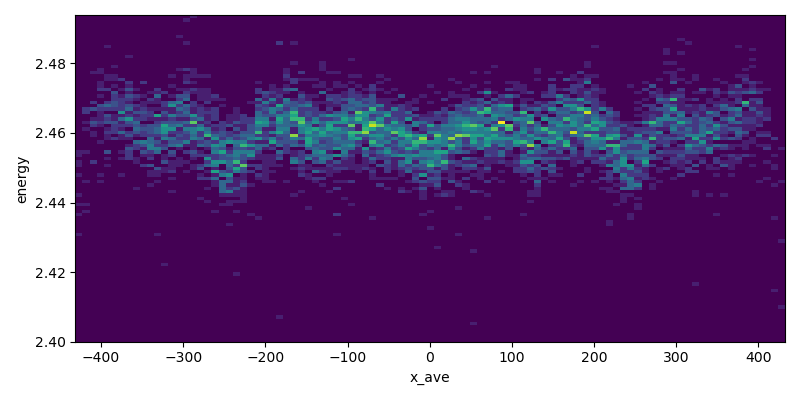

In [117]:
plt.figure(figsize=[8, 4])

xlabel = "x_ave"
ylabel = "energy"

x = tracks_0nubb.get(xlabel)
y = tracks_0nubb.get(ylabel)

xbins = np.linspace(x.min(), x.max(), 100)
ybins = np.linspace(2.4, y.max(), 100)

plt.hist2d( x, y, bins=[xbins, ybins])

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.tight_layout();

In [129]:
# from invisible_cities.reco.corrections import read_maps

# maps = read_maps("/Users/gonzalo/NEXT/DATA/production/LightTables/map_NEXT100_MC.h5")

# plt.figure(figsize=[9, 3])
# plt.subplot(121)
# plt.imshow(maps.e0)

# plt.subplot(122)
# plt.imshow(maps.lt)

# plt.tight_layout()